In [5]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_dir = "./data"

device = torch.device("cpu")

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

if torch.cuda.is_available():
    device = torch.device("cuda")

print(f"Data resides in        : {data_dir}")
print(f"Training model on      : {str(device)}")

Data resides in        : ./data
Training model on      : mps


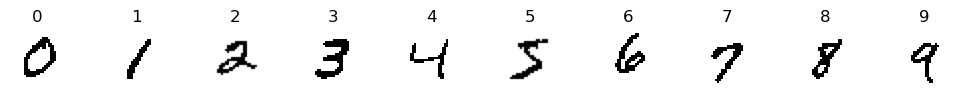

In [6]:
def print_samples(samples, elements_per_row=10, fig_width=10, cmap="binary"):
    num_digits = len(samples)
    num_rows = (num_digits + elements_per_row - 1) // elements_per_row

    plt.figure(figsize=(fig_width, fig_width / elements_per_row * num_rows))
    for idx, (label, image) in enumerate(samples):
        plt.subplot(num_rows, elements_per_row, idx + 1)
        plt.imshow(image.squeeze(), cmap=cmap)
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# load MNIST and convert it to binary directly in transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),               # normalize to [0, 1]
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

sample_list = [(label, next(image for image, lbl in train_dataset if lbl == label)) for label in range(10)]
print_samples(sample_list)

In [7]:
class RBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim=128, W_var=0.01, a_val=0.0, b_val=0.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(visible_dim, hidden_dim) * W_var)
        self.a = nn.Parameter(torch.full((visible_dim,), a_val))
        self.b = nn.Parameter(torch.full((hidden_dim,), b_val))

    def sample_hidden(self, v):
        h_probs = torch.sigmoid(v @ self.W + self.b)
        h_sample = torch.bernoulli(h_probs)
        return h_probs, h_sample

    def sample_visible(self, h):
        v_probs = torch.sigmoid(h @ self.W.t() + self.a)
        v_sample = torch.bernoulli(v_probs)
        return v_probs, v_sample

    def sample_gibbs(self, v, k=1):
        vk_probs = torch.zeros_like(v)
        vk_sample = v.clone()
        for _ in range(k):
            _, hk_sample = self.sample_hidden(vk_sample)
            vk_probs, vk_sample = self.sample_visible(hk_sample)
        return vk_probs, vk_sample

    def contrastive_divergence(self, v0, k=1, lr=0.01):
        # positive phase
        h0_probs, h0_sample = self.sample_hidden(v0)

        # negative phase
        _, vk = self.sample_gibbs(v0, k)

        # calculate associations
        positive_association = v0.t() @ h0_probs
        negative_association = vk.t() @ torch.sigmoid(vk @ self.W + self.b)

        # parameter step
        self.W.data += lr * (positive_association - negative_association) / v0.size(0)
        self.a.data += lr * (v0.mean(dim=0) - vk.mean(dim=0))
        self.b.data += lr * (h0_probs.mean(dim=0) - torch.sigmoid(vk @ self.W + self.b).mean(dim=0))

        return vk

In [8]:
hidden_dim = 512
batch_size = 64
epochs = 20
lr = 0.01
gibbs_steps = 1


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


visible_dim = train_dataset[0][0].numel()
rbm = RBM(visible_dim, hidden_dim).to(device)


metrics = {}
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch, _ in train_loader:
        flat_batch = batch.view(-1, visible_dim).to(device)

        recon_batch = rbm.contrastive_divergence(flat_batch, k=gibbs_steps)

        loss = torch.mean(torch.sum((flat_batch - recon_batch) ** 2, dim=1))
        epoch_loss += loss.item()

    metrics[epoch] = { "reconstruction_error": epoch_loss / len(train_loader) }
    print(f"Epoch {epoch + 1}/{epochs} : Loss {metrics[epoch]['reconstruction_error']:.4f}")

Epoch 1/20 : Loss 113.0251
Epoch 2/20 : Loss 80.0800
Epoch 3/20 : Loss 68.7925
Epoch 4/20 : Loss 62.0766
Epoch 5/20 : Loss 57.4295
Epoch 6/20 : Loss 53.8960
Epoch 7/20 : Loss 51.0999
Epoch 8/20 : Loss 48.9190
Epoch 9/20 : Loss 46.9514
Epoch 10/20 : Loss 45.3542
Epoch 11/20 : Loss 43.9307
Epoch 12/20 : Loss 42.6697
Epoch 13/20 : Loss 41.5028
Epoch 14/20 : Loss 40.5451
Epoch 15/20 : Loss 39.6257
Epoch 16/20 : Loss 38.7894
Epoch 17/20 : Loss 37.9605
Epoch 18/20 : Loss 37.2673
Epoch 19/20 : Loss 36.6197
Epoch 20/20 : Loss 36.0114


Text(0, 0.5, 'Reconstruction Error')

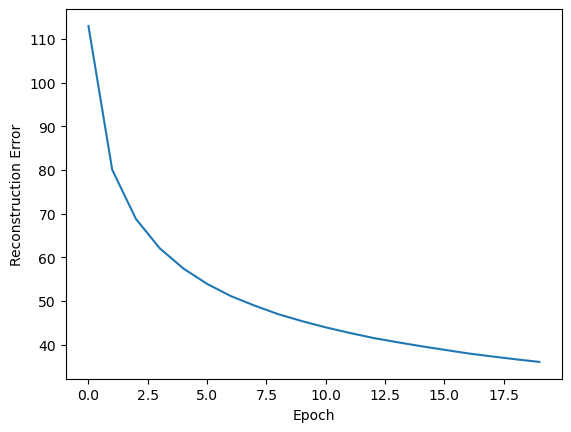

In [9]:
# only plot the reconstruction_error
plt.plot([metrics[epoch]['reconstruction_error'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

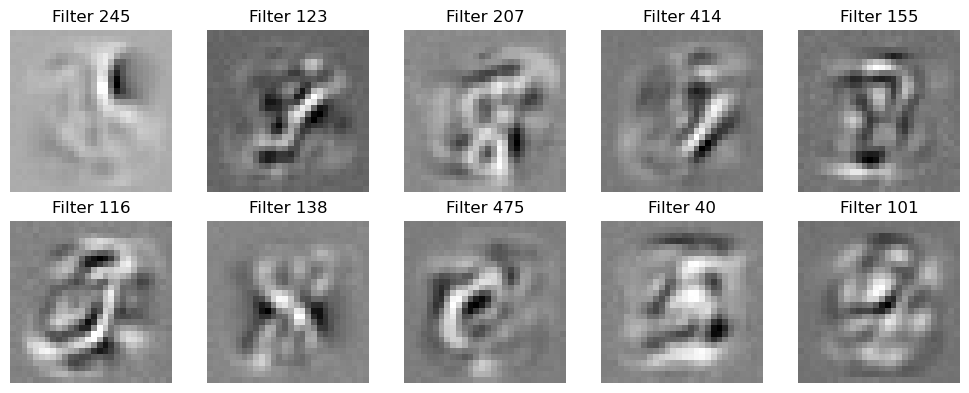

In [11]:
# the weights have shape (visible_dim, hidden_dim), we can transpose to get some kind of filter view for the hidden ones
hidden_columns = rbm.W.t().detach().cpu().view(hidden_dim, 28, 28)
filter_idx = torch.randint(0, hidden_dim, (10,))
filter_samples = [(f"Filter {idx.item()}", hidden_columns[idx]) for idx in filter_idx]
print_samples(filter_samples, elements_per_row=5, cmap="gray")

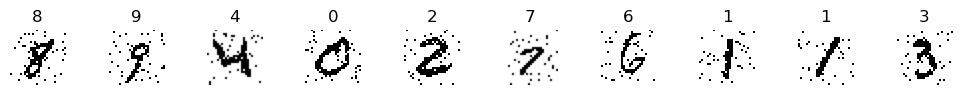

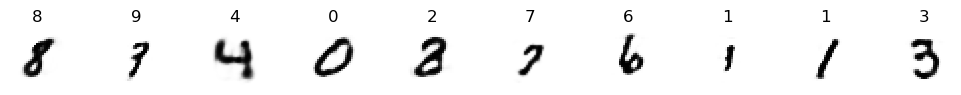

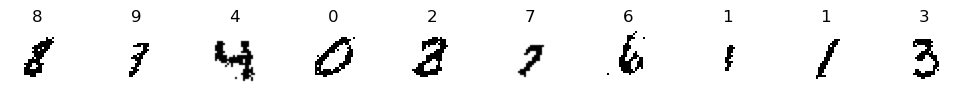

In [12]:
# getting some random samples with noise
random_labels = torch.randint(0, 10, (10,))
noise_level = 0.05

demo_samples = []
label_idx = 0

for image, lbl in train_dataset:
    if label_idx >= len(random_labels):
        break

    if lbl == random_labels[label_idx]:
        demo_samples.append((lbl, image))

        noise = torch.rand_like(image)
        image[noise < noise_level] = 1 - image[noise < noise_level]

        label_idx += 1


# performing reconstruction
demo_recon_probs = []
demo_recon_samples = []
with torch.no_grad():
    for digit, sample in demo_samples:
        flat_sample = sample.view(-1, visible_dim).to(device)

        v_probs, v_sample = rbm.sample_gibbs(flat_sample, k=10)

        demo_recon_probs.append((digit, v_probs.view(28, 28).cpu()))
        demo_recon_samples.append((digit, v_sample.view(28, 28).cpu()))


inverted_demo_recon_probs = [(digit, 1 - v_prob) for digit, v_prob in demo_recon_probs]

print_samples(demo_samples, elements_per_row=10, cmap="binary")
print_samples(inverted_demo_recon_probs, elements_per_row=10, cmap="gray")
print_samples(demo_recon_samples, elements_per_row=10, cmap="binary")

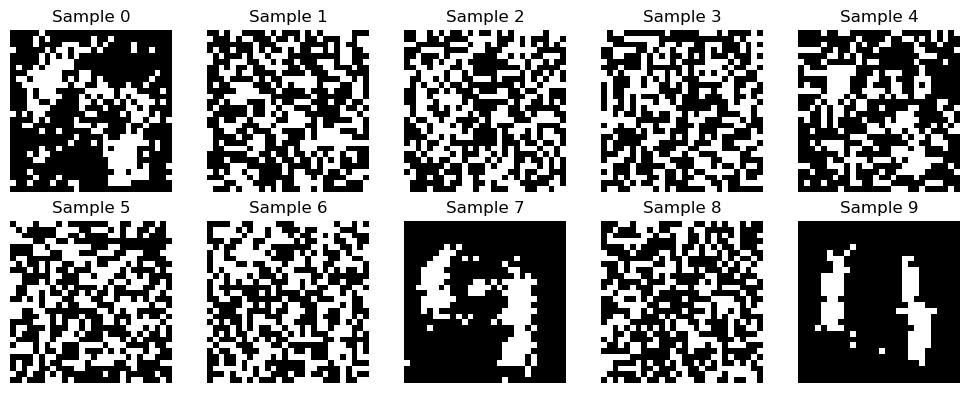

In [21]:
# generation starting from random noise
generation_steps = 40

with torch.no_grad():
    random_samples = torch.bernoulli(torch.rand(10, visible_dim)).to(device)
    _, random_recon = rbm.sample_gibbs(random_samples, k=generation_steps)

    random_recon = random_recon.view(-1, 28, 28).cpu()

print_samples([(f"Sample {idx}", sample) for idx, sample in enumerate(random_recon)], elements_per_row=5, cmap="gray")